In [7]:
import pandas as pd
import matplotlib.pyplot as plt

In [8]:
data = pd.read_csv('~/Downloads/wandb_export_2025-06-12T09_13_49.744-04_00.csv')
data

,iter,gentle-snowball-198 - _step,gentle-snowball-198 - _step__MIN,gentle-snowball-198 - _step__MAX,gentle-snowball-198 - val_bleu_score,gentle-snowball-198 - val_bleu_score__MIN,gentle-snowball-198 - val_bleu_score__MAX,gentle-snowball-198 - train_bleu_score,gentle-snowball-198 - train_bleu_score__MIN,gentle-snowball-198 - train_bleu_score__MAX
0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2000,1,1,1,0.045775,0.045775,0.045775,0.044067,0.044067,0.044067
2,4000,2,2,2,0.206540,0.206540,0.206540,0.223155,0.223155,0.223155
3,6000,3,3,3,0.245136,0.245136,0.245136,0.273549,0.273549,0.273549
4,8000,4,4,4,0.259564,0.259564,0.259564,0.299790,0.299790,0.299790
...,...,...,...,...,...,...,...,...,...,...
110,220000,110,110,110,0.349485,0.349485,0.349485,0.437278,0.437278,0.437278
111,222000,111,111,111,0.350281,0.350281,0.350281,0.438408,0.438408,0.438408
112,224000,112,112,112,0.350078,0.350078,0.350078,0.436815,0.436815,0.436815
113,226000,113,113,113,0.350841,0.350841,0.350841,0.437889,0.437889,0.437889


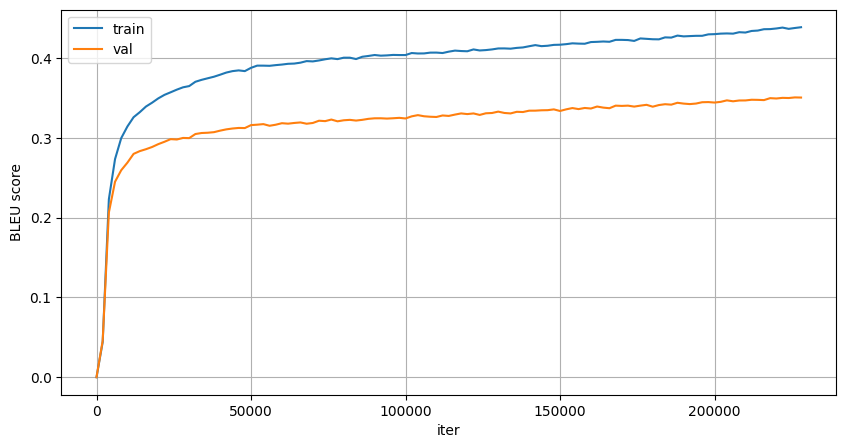

In [11]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(data['iter'], data['gentle-snowball-198 - train_bleu_score'], label='train')
ax.plot(data['iter'], data['gentle-snowball-198 - val_bleu_score'], label='val')
ax.legend()
ax.grid()
ax.set_xlabel('iter')
ax.set_ylabel('BLEU score')
plt.savefig('/Users/adam.amster/aamster.github.io/assets/img/2025-04-13-sequence_to_sequence_translation/encoder_decoder_perf.png')
plt.show()

In [9]:
test_perf = pd.read_csv('~/Downloads/eval_main.csv')
test_perf['bleu'].mean()

0.3862500656953809

In [5]:
from concurrent.futures import as_completed
from tqdm import tqdm
from seq2seq_translation.tokenization.sentencepiece_tokenizer import SentencePieceTokenizer
from seq2seq_translation.datasets.wmt14 import WMT14
from concurrent.futures import ThreadPoolExecutor
import numpy as np
import os

wmt14 = WMT14(data_path='/Users/adam.amster/seq2seq_translation/datasets/wmt14_train/fr-en', source_lang='en', target_lang='fr', split='train')
source_tokenizer = SentencePieceTokenizer(model_prefix='/Users/adam.amster/seq2seq_translation/tokenizer/30000/en')
target_tokenizer = SentencePieceTokenizer(model_prefix='/Users/adam.amster/seq2seq_translation/tokenizer/30000/fr')

def token_count(idx, max_len=128):
    target, source = wmt14[idx][:-1]
    return (len(source_tokenizer.processor.encode(source)[:max_len]),
                    len(target_tokenizer.processor.encode(target)[:max_len]))

futures = []
idxs = np.arange(len(wmt14))
np.random.shuffle(idxs)
idxs = idxs[:int(len(idxs) * .01)]
with ThreadPoolExecutor(max_workers=os.cpu_count()) as ex:
    for idx in idxs:
        futures.append(ex.submit(token_count, idx))

    lengths = []
    for fut in tqdm(as_completed(futures), total=len(futures),
                    desc="Counting tokens"):
        lengths.append(fut.result())


Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Counting tokens: 100%|██████████| 408367/408367 [01:21<00:00, 5024.02it/s]


In [6]:
lengths = np.array(lengths)
print(lengths.mean(), lengths.std(), np.quantile(lengths, 0.5))

49.59853758996197 30.25773669114214 43.0


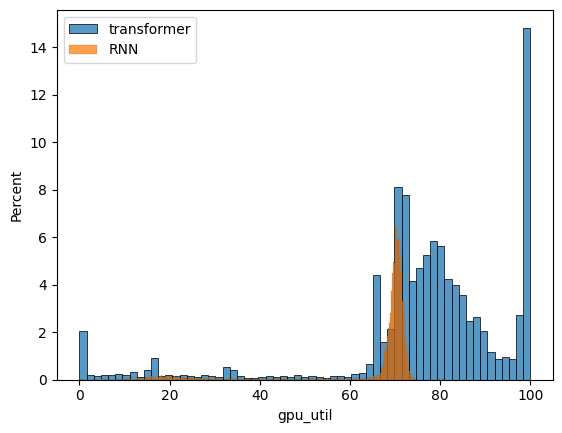

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

transformer_gpu_util = pd.read_csv('~/Downloads/wandb_export_2025-06-22T13_16_25.728-04_00.csv')
rnn_gpu_util = pd.read_csv('~/Downloads/wandb_export_2025-06-22T13_17_12.253-04_00.csv')

transformer_gpu_util['gpu_util'] = (transformer_gpu_util['gentle-snowball-198 - system/gpu.0.gpu'] + transformer_gpu_util['gentle-snowball-198 - system/gpu.1.gpu'] + transformer_gpu_util['gentle-snowball-198 - system/gpu.2.gpu']) / 3

rnn_gpu_util['gpu_util'] = (rnn_gpu_util['pleasant-shadow-169 - system/gpu.0.gpu'] + rnn_gpu_util['pleasant-shadow-169 - system/gpu.1.gpu'] + rnn_gpu_util['pleasant-shadow-169 - system/gpu.2.gpu']) / 3


sns.histplot(transformer_gpu_util['gpu_util'], label='transformer', stat='percent')
sns.histplot(rnn_gpu_util['gpu_util'], label='RNN', stat='percent')
plt.legend()
plt.show()